In [1]:
#Importation des différentes librairies et définition de la taille des figures
import os
import pandas as pd
import warnings
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns

from tqdm import tqdm
from random import randint
from tqdm.auto import tqdm
from scipy.stats import entropy
import time
from sklearn.decomposition import PCA

plt.rcParams["figure.figsize"] = (20, 16)
warnings.simplefilter("ignore")

Ce notebook effectue des calculs sur les différentes captures du CTU-13, disponibles ici: https://www.stratosphereips.org/datasets-ctu13

Pour effectuer les calculs, il est nécessaires d'avoir les captures en locales, précisémment d'avoir téléchargé et dézippé le fichier CTU-13-Dataset.tar.bz2 disponible sur le lien ci-dessus.

In [2]:
#Current_dataset: numéro du dataset à analyser (correspondant au numéro de son dossier)
current_dataset = 6
#name_directory: chemin relatif vers le document dézippé
name_directory = "../Downloads/UTC-13"
path = os.path.join(name_directory,str(current_dataset))
os.listdir(path)

['botnet-capture-20110816-donbot.pcap', 'capture20110816.binetflow', 'README']

In [3]:
[i for i in os.listdir(path) if i.endswith(".binetflow") ]

['capture20110816.binetflow']

In [4]:
datafile_name = [i for i in os.listdir(path) if i.endswith(".binetflow") ][0]
df = pd.read_csv(os.path.join(path,datafile_name))
df

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/16 10:04:03.820235,0.286751,tcp,67.210.234.162,3597,->,147.32.86.98,80,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
1,2011/08/16 10:04:04.106986,0.280358,tcp,67.210.234.162,3597,->,147.32.86.98,80,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
2,2011/08/16 10:04:04.387344,0.280039,tcp,67.210.234.162,3597,->,147.32.86.98,80,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
3,2011/08/16 10:02:54.155092,138.123184,tcp,147.32.84.59,49158,->,147.32.80.7,80,SRPA_FSPA,0.0,0.0,12,2636,638,flow=Background-Established-cmpgw-CVUT
4,2011/08/16 10:07:24.648890,0.306994,tcp,67.210.234.171,3255,->,147.32.84.142,80,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558914,2011/08/16 12:10:56.783227,0.000241,udp,147.32.84.59,47132,<->,147.32.80.9,53,CON,0.0,0.0,2,230,90,flow=To-Background-UDP-CVUT-DNS-Server
558915,2011/08/16 12:10:56.783863,0.000360,udp,147.32.84.59,33462,<->,147.32.80.9,53,CON,0.0,0.0,2,307,86,flow=To-Background-UDP-CVUT-DNS-Server
558916,2011/08/16 12:10:56.783922,0.000419,udp,147.32.84.59,50059,<->,147.32.80.9,53,CON,0.0,0.0,2,254,77,flow=To-Background-UDP-CVUT-DNS-Server
558917,2011/08/16 12:10:56.802376,0.041333,tcp,84.42.129.253,33357,->,147.32.84.36,443,SPA_SPA,0.0,0.0,15,6824,1142,flow=Background-TCP-Established


In [5]:
#Calcul du volume total de trafic en Octets
def vol_df(df):
    vol_total = 0
    for i in df['TotBytes']:
        vol_total += i
    return vol_total

print("- Volume total de trafic pour le dataset:", round(vol_df(df)/1000000000,2), "Giga Octets.")

#Calcul des Durées moyennes des connexions
def duree_moy_con(df):
    duree_total_con = 0
    for i in df['Dur']:
        duree_total_con += i
    return duree_total_con/len(df['Dur'])

print("- Durée moyenne des connexions pour le dataset:", round(duree_moy_con(df)/60,2), "minutes.")

- Volume total de trafic pour le dataset: 31.19 Giga Octets.
- Durée moyenne des connexions pour le dataset: 4.07 minutes.


In [6]:
#Calcul du nombre moyen de connexions par IP
def moy_conn_IP(df):
    dic_moy_IP = {}
    for i in range(0, len(df['Dur'])):
        if(df.iloc[i]['SrcAddr'] not in dic_moy_IP):
            dic_moy_IP[df.iloc[i]['SrcAddr']] = 0
        dic_moy_IP[df.iloc[i]['SrcAddr']] += 1
        if(df.iloc[i]['DstAddr'] not in dic_moy_IP):
            dic_moy_IP[df.iloc[i]['DstAddr']] = 0
        dic_moy_IP[df.iloc[i]['DstAddr']] += 1
    nb_moy_conn_IP = 0
    for key in dic_moy_IP:
        nb_moy_conn_IP += dic_moy_IP[key]
    return nb_moy_conn_IP/len(dic_moy_IP)
print("- Nombre moyen de connexions par IP:", round(moy_conn_IP(df),2))

- Nombre moyen de connexions par IP: 10.41


In [7]:
#Calcul de la répartition du trafic par protocole
def repart_traf_par_proto(df):
    dic_traf_proto = {}
    for i in range(0, len(df['Dur'])):
        if(df.iloc[i]['Proto'] not in dic_traf_proto):
            dic_traf_proto[df.iloc[i]['Proto']] = 0
        dic_traf_proto[df.iloc[i]['Proto']] += df.iloc[i]['TotBytes']
    traf_tot = vol_df(df)
    for key in dic_traf_proto:
        dic_traf_proto[key] = round(dic_traf_proto[key]/traf_tot,4)
    return dic_traf_proto
repart_traf_proto = repart_traf_par_proto(df)
print("- Répartition du trafic par protocole:", repart_traf_proto)

- Répartition du trafic par protocole: {'tcp': 0.7758, 'udp': 0.2231, 'ipx/spx': 0.0, 'arp': 0.0, 'icmp': 0.0003, 'pim': 0.0, 'rtcp': 0.0, 'rtp': 0.0, 'igmp': 0.0, 'ipv6-icmp': 0.0, 'esp': 0.0008, 'ipv6': 0.0, 'udt': 0.0}


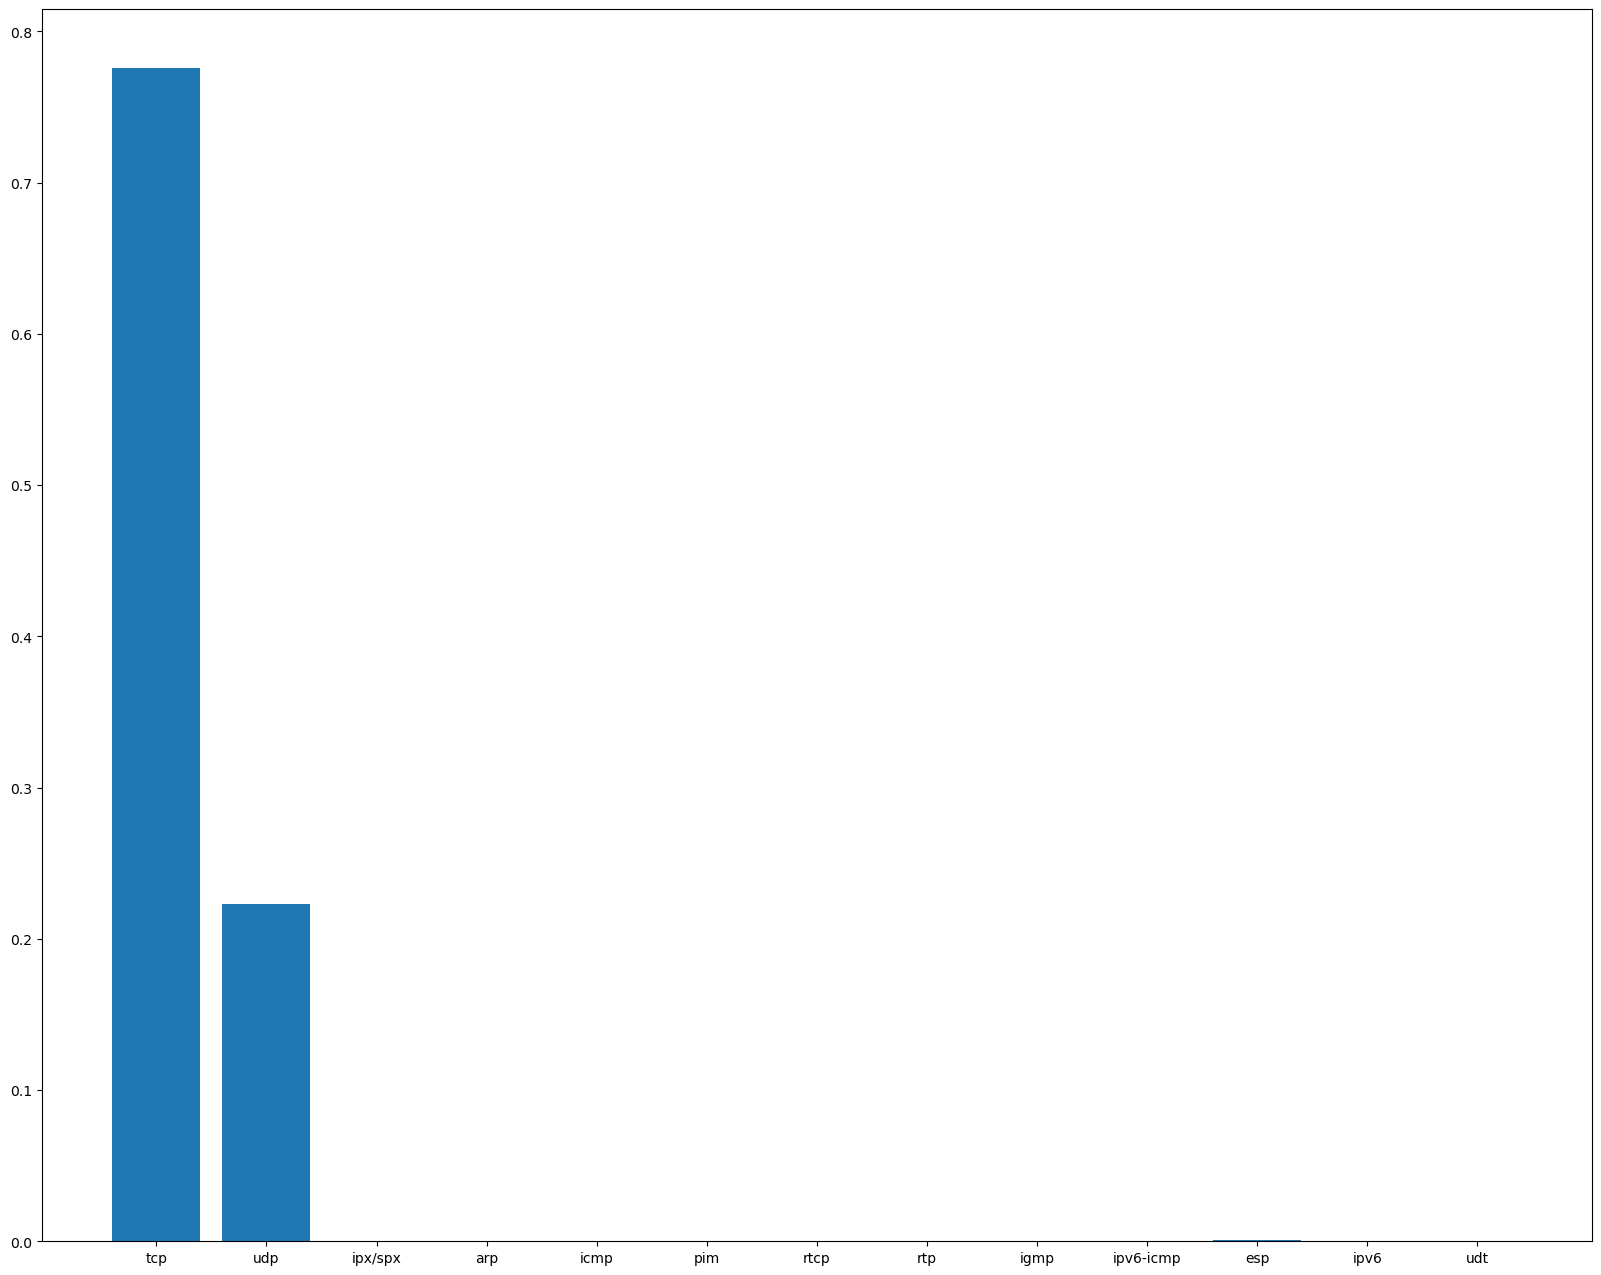

In [8]:
#Génération du graphique associé
x = list(repart_traf_proto.keys())
y = list(repart_traf_proto.values())

fix, ax = plt.subplots()
ax.bar(x, height=y)
plt.show()

<AxesSubplot:>

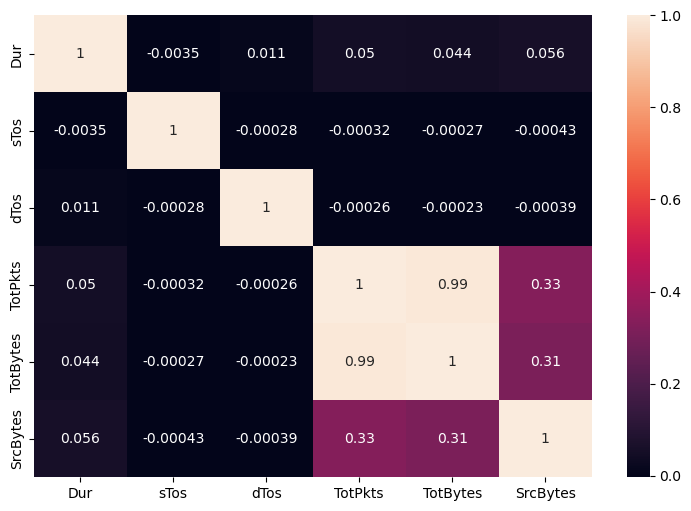

In [9]:
#Matrice de corrélation

corr_matrix = df.corr()

plt.rcParams["figure.figsize"]=(9,6)
sns.heatmap(corr_matrix, annot=True)

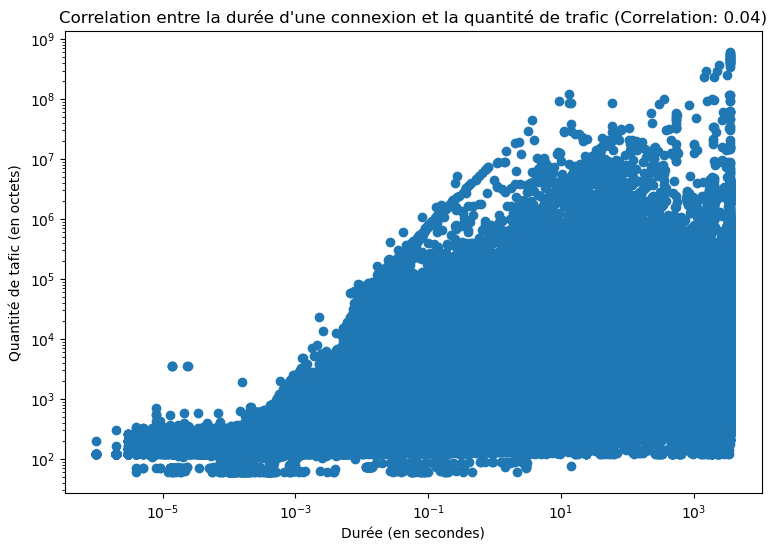

In [10]:
#Analyse de correlation entre le volume de trafic et la durée des connexions
corr_value = df['Dur'].corr(df['TotBytes'])

fig, ax = plt.subplots()
ax.scatter(df['Dur'], df['TotBytes'])

# Mise à l'échelle logarithmique
ax.set_xscale('log')
ax.set_yscale('log')

plt.title(f"Correlation entre la durée d'une connexion et la quantité de trafic (Correlation: {corr_value:.2f})")
plt.xlabel("Durée (en secondes)")
plt.ylabel("Quantité de tafic (en octets)")

plt.show()

In [11]:
#Test: la connexion avec le plus de trafic est-elle labélisée comme botnet?
max = 0
j = 0
for i in range(0, len(df['Dur'])):
    if df.iloc[i]['TotBytes']>max:
        max = df.iloc[i]['TotBytes']
        j = 1
print(df.iloc[j]['Label'])
print("La donnée avec le plus de connexion n'est pas labélise comme un botnet")

flow=Background-TCP-Attempt
La donnée avec le plus de connexion n'est pas labélise comme un botnet
